In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

from matplotlib import pyplot as plt
import pandas
import src
import gensim
import os
import os.path
import csv
import functools
import itertools
import scipy.stats
from operator import itemgetter

INFO:gensim.corpora.sharded_corpus:Could not import Theano, will use standard float for default ShardedCorpus dtype.
2015-12-20 20:37:47 twoism gensim.corpora.sharded_corpus[19070] INFO Could not import Theano, will use standard float for default ShardedCorpus dtype.
INFO:summa.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English
2015-12-20 20:37:47 twoism summa.preprocessing.cleaner[19070] INFO 'pattern' package not found; tag filters are not available for English


In [3]:
def get_n_closest(l, avg, n):
    diffs = [abs(avg - item) for item in list(l)]
    diffs = sorted(enumerate(diffs), key=lambda x: x[1])
    return [x for x, y in diffs[:n]]    

In [4]:
rankfiles = dict()
runsloc = '/mnt/6000/thesis-data/runs'
for dirpath, dirname, filenames in os.walk(runsloc):
    for filename in filenames:
        if filename.endswith("-ranks.csv.gz"):
            _, num, _, name, version = dirpath.replace(runsloc, '').split('/')
            name = name.title().replace("keeper", "Keeper").replace("Openjpa", "OpenJPA") + " " + version
            if name not in rankfiles:
                rankfiles[name] = {'changeset': {'feature_location': list(),
                                                 'triage': list()},
                                   'release': {'feature_location': list(),
                                               'triage': list()},
                                  }
                
            parts = filename.split('-')
            rankfiles[name][parts[0]][parts[1]].append((int(num), os.path.join(dirpath, filename)))

for name, source in rankfiles.items():
    for source, exps in source.items():
        for exp, filenames in exps.items():
            rankfiles[name][source][exp] = [x for _, x in sorted(filenames)]

In [5]:
rankfiles

{'BookKeeper v4.3.0': {'changeset': {'feature_location': ['/mnt/6000/thesis-data/runs/1/data/bookkeeper/v4.3.0/changeset-feature_location-lda-true-true-false-true-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz',
    '/mnt/6000/thesis-data/runs/2/data/bookkeeper/v4.3.0/changeset-feature_location-lda-true-true-false-true-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz',
    '/mnt/6000/thesis-data/runs/3/data/bookkeeper/v4.3.0/changeset-feature_location-lda-true-true-false-true-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz',
    '/mnt/6000/thesis-data/runs/4/data/bookkeeper/v4.3.0/changeset-feature_location-lda-true-true-false-true-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz',
    '/mnt/6000/thesis-data/runs/5/data/bookkeeper/v4.3.0/changeset-feature_location-lda-true-true-false-true-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz',
    '/mnt/6000/thesis-data/runs/6/data/bookkeeper/v4.3.0/changeset-feature_location-lda-tru

In [6]:
df = pandas.DataFrame()
for name, source in rankfiles.items():
    for source, exps in source.items():
        for exp, filenames in exps.items():
            mrr = list()
            for each in filenames:
                try:
                    data = pandas.read_csv(each)
                except Exception:
                    print("error reading %s" % each)
                    continue
                mrr.append(src.utils.calculate_mrr(list(data.groupby("id")["rank"].min())))
                
                if len(data[data["distance"] == 1.0]):
                    print(each)
        
            mrr = pandas.Series(mrr)       
            df = df.append(
              {'subject': name, 
               'source': source,
               'experiment': exp,
               'std': mrr.std(),
               'max-min': mrr.max() - mrr.min(),
               'max': mrr.max(),
               'median': mrr.median(),
               'min': mrr.min(),
               'count': mrr.count(),
               'raw': mrr,
              }, ignore_index=True)

In [7]:
df

,count,experiment,max,max-min,median,min,raw,source,std,subject
0,50,feature_location,0.632899,0.197898,0.527520,0.435000,0 0.629664 1 0.528044 2 0.542754 3...,release,0.052961,Tika v1.8
1,50,triage,0.616243,0.172525,0.519302,0.443718,0 0.463261 1 0.535387 2 0.450338 3...,release,0.042177,Tika v1.8
2,50,feature_location,0.605296,0.164596,0.514738,0.440700,0 0.587672 1 0.480646 2 0.491845 3...,changeset,0.038565,Tika v1.8
3,50,triage,0.480468,0.163620,0.402666,0.316848,0 0.416654 1 0.368810 2 0.381680 3...,changeset,0.029897,Tika v1.8
4,50,feature_location,0.368762,0.095590,0.312443,0.273172,0 0.293907 1 0.295913 2 0.294065 3...,release,0.020992,OpenJPA v2.3.0
5,50,triage,0.336067,0.083905,0.293648,0.252162,0 0.312537 1 0.271933 2 0.277477 3...,release,0.018056,OpenJPA v2.3.0
6,50,feature_location,0.383814,0.084180,0.329169,0.299635,0 0.378652 1 0.365795 2 0.320250 3...,changeset,0.021415,OpenJPA v2.3.0
7,50,triage,0.396865,0.115202,0.344560,0.281663,0 0.350950 1 0.349138 2 0.330240 3...,changeset,0.023844,OpenJPA v2.3.0
8,50,feature_location,0.482366,0.069649,0.449593,0.412717,0 0.457013 1 0.432943 2 0.439077 3...,release,0.015429,Pig v0.14.0
9,50,triage,0.619278,0.098386,0.575613,0.520892,0 0.568820 1 0.561572 2 0.550892 3...,release,0.021537,Pig v0.14.0


In [22]:
for plotname, indices in df.groupby(["source", "experiment"]).groups.items():
    source, exp = plotname
    for s, each in enumerate(indices):
        row = df.ix[each]
        c = row.raw.ix[get_n_closest(row.raw, row.raw.median(), 1)]
        run = c.index[0]
        mrr = c.values[0]
        print(row.subject, source, exp, run, mrr, rankfiles[row.subject][source][exp][run - 1])

Tika v1.8 release triage 3 0.520645645646 /mnt/6000/thesis-data/runs/3/data/tika/v1.8/release-triage-lda-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz
OpenJPA v2.3.0 release triage 21 0.294058865528 /mnt/6000/thesis-data/runs/21/data/openjpa/v2.3.0/release-triage-lda-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz
Pig v0.14.0 release triage 13 0.576243791402 /mnt/6000/thesis-data/runs/13/data/pig/v0.14.0/release-triage-lda-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz
Mahout v0.10.0 release triage 25 0.276849978122 /mnt/6000/thesis-data/runs/25/data/mahout/v0.10.0/release-triage-lda-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz
BookKeeper v4.3.0 release triage 2 0.684552845528 /mnt/6000/thesis-data/runs/2/data/bookkeeper/v4.3.0/release-triage-lda-batch-0.002-0.5-0.002-1000-1000-500-1.0-1-file-ranks.csv.gz
ZooKeeper v3.5.0 release triage 28 0.511760663297 /mnt/6000/thesis-data/runs/28/data/zookeeper/v3.5.0/release-triage-lda-batch-0.

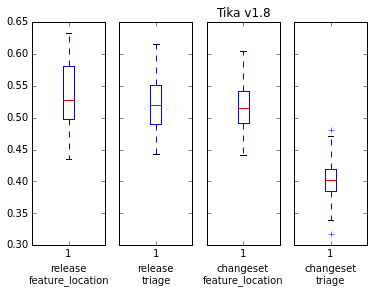

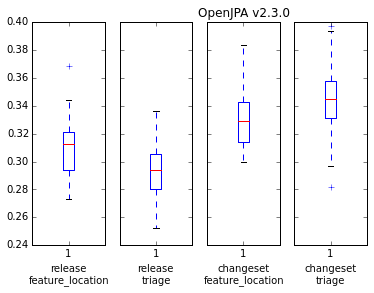

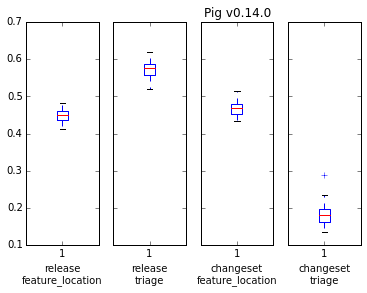

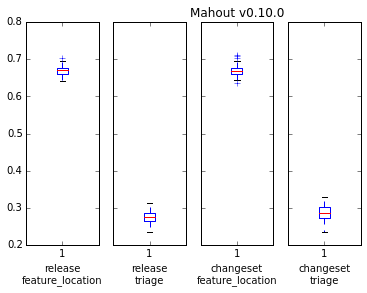

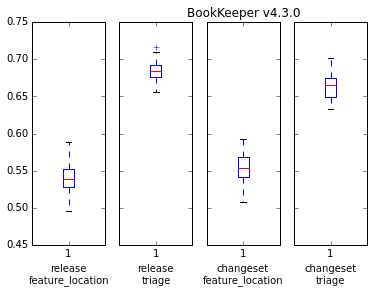

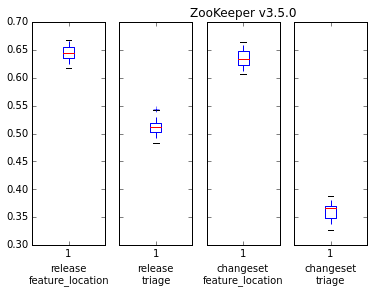

In [21]:
for plotname, indices in df.groupby(["subject"]).groups.items():
    fig, axarr = plt.subplots(1, 4, sharey=True)
    axarr[2].set_title(plotname)
    for s, each in enumerate(indices):
        exp = df.ix[each]
        if (exp["min"] == 1.0):
            continue
        axarr[s].boxplot(exp.raw)
        axarr[s].set_xlabel(exp.source + "\n" + exp.experiment)
    plt.show()

In [10]:
main_df = pandas.DataFrame(columns=["Subject", "Source", "Task", "Run", "Issue", "Rank", "Distance"])

for name, source in rankfiles.items():
    for source, exps in source.items():
        for exp, filenames in exps.items():
            for run_no, each in enumerate(filenames):
                try:
                    data = pandas.read_csv(each)
                except Exception:
                    print("error reading %s" % each)
                    continue
                
                if len(data[data["distance"] == 1.0]):
                    print(each)

                subdf = pandas.DataFrame(columns=main_df.columns)
                subdf["Rank"] = data.groupby("id")["rank"].min().values
                subdf["Distance"] = data.groupby("id")["distance"].min().values
                subdf["Issue"] = data.groupby("id")["rank"].min().index
                subdf["Subject"] = subdf.Subject.fillna(name)
                subdf["Source"] = subdf.Source.fillna(source)
                subdf["Task"] = subdf.Task.fillna(exp)
                subdf["Run"] = subdf.Run.fillna(run_no + 1)
            
                main_df = main_df.append(subdf, ignore_index=True)

In [11]:
main_df

,Subject,Source,Task,Run,Issue,Rank,Distance
0,Tika v1.8,release,feature_location,1,241,6,0.840085
1,Tika v1.8,release,feature_location,1,936,1,0.716169
2,Tika v1.8,release,feature_location,1,995,1,0.618076
3,Tika v1.8,release,feature_location,1,1028,1,0.689249
4,Tika v1.8,release,feature_location,1,1269,1,0.751529
5,Tika v1.8,release,feature_location,1,1286,1,0.591962
6,Tika v1.8,release,feature_location,1,1365,653,0.994449
7,Tika v1.8,release,feature_location,1,1383,17,0.871618
8,Tika v1.8,release,feature_location,1,1416,1,0.685607
9,Tika v1.8,release,feature_location,1,1423,35,0.890196


In [12]:
stat_df = pandas.DataFrame(columns=["Subject", "Source", "Task", "Friedman", "NumSig"])
for key, group in main_df.groupby(["Subject", "Source", "Task"]):
    ranks = list()
    for subkey, subgroup in group.groupby(["Run"]):
        ranks.append(subgroup.Rank)
    stat, p = scipy.stats.friedmanchisquare(*ranks)
    
    sigs = list()
    for x, y in itertools.combinations(main_df.Run.unique(), r=2):
        try:
            stat, p = scipy.stats.wilcoxon(group[group.Run == x].Rank, group[group.Run == y].Rank)
        except ValueError as e:
            print(e, x, y)
            continue
        if p < 0.05:
            sigs.append((x,y))
    s = len(sigs)   
    stat_df = stat_df.append(dict(zip(stat_df.columns, itertools.chain(key, [p, s]))), ignore_index=True)    
    
k = len(list(itertools.combinations(main_df.Run.unique(), r=2)))
stat_df["PercSig"] = stat_df.NumSig / k

In [13]:
stat_df

,Subject,Source,Task,Friedman,NumSig,PercSig
0,BookKeeper v4.3.0,changeset,feature_location,0.946700,42,0.034286
1,BookKeeper v4.3.0,changeset,triage,0.019784,765,0.624490
2,BookKeeper v4.3.0,release,feature_location,0.725799,110,0.089796
3,BookKeeper v4.3.0,release,triage,0.237849,101,0.082449
4,Mahout v0.10.0,changeset,feature_location,0.299794,69,0.056327
5,Mahout v0.10.0,changeset,triage,0.650986,272,0.222041
6,Mahout v0.10.0,release,feature_location,0.685240,85,0.069388
7,Mahout v0.10.0,release,triage,0.325798,59,0.048163
8,OpenJPA v2.3.0,changeset,feature_location,0.244359,118,0.096327
9,OpenJPA v2.3.0,changeset,triage,0.075530,314,0.256327


In [14]:
stat_df[stat_df.Friedman < 0.05]

,Subject,Source,Task,Friedman,NumSig,PercSig
1,BookKeeper v4.3.0,changeset,triage,0.019784,765,0.624490
12,Pig v0.14.0,changeset,feature_location,0.033458,191,0.155918
17,Tika v1.8,changeset,triage,0.038425,91,0.074286
21,ZooKeeper v3.5.0,changeset,triage,0.023875,707,0.577143


In [20]:
stat_df[stat_df.Friedman < 0.1]

,Subject,Source,Task,Friedman,NumSig,PercSig
1,BookKeeper v4.3.0,changeset,triage,0.019784,765,0.624490
9,OpenJPA v2.3.0,changeset,triage,0.075530,314,0.256327
11,OpenJPA v2.3.0,release,triage,0.066223,128,0.104490
12,Pig v0.14.0,changeset,feature_location,0.033458,191,0.155918
17,Tika v1.8,changeset,triage,0.038425,91,0.074286
21,ZooKeeper v3.5.0,changeset,triage,0.023875,707,0.577143


In [15]:
stat_df[stat_df.PercSig >= 0.25]

,Subject,Source,Task,Friedman,NumSig,PercSig
1,BookKeeper v4.3.0,changeset,triage,0.019784,765,0.624490
9,OpenJPA v2.3.0,changeset,triage,0.075530,314,0.256327
13,Pig v0.14.0,changeset,triage,0.113500,935,0.763265
21,ZooKeeper v3.5.0,changeset,triage,0.023875,707,0.577143


In [16]:
stat_df[(stat_df.PercSig >= 0.1) & (stat_df.PercSig < 0.25)]

,Subject,Source,Task,Friedman,NumSig,PercSig
5,Mahout v0.10.0,changeset,triage,0.650986,272,0.222041
10,OpenJPA v2.3.0,release,feature_location,0.488013,191,0.155918
11,OpenJPA v2.3.0,release,triage,0.066223,128,0.104490
12,Pig v0.14.0,changeset,feature_location,0.033458,191,0.155918
14,Pig v0.14.0,release,feature_location,0.903698,246,0.200816
15,Pig v0.14.0,release,triage,0.597372,140,0.114286
